# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("ResNet50_Unfreeze")
mlflow.set_tag("mlflow.runName", "RestNet50_Unfreeze_version_1")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated_ResNet50')

2025/06/25 15:56:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
def transformed_image(image_path:str) -> torch.tensor:
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil)
    return image_tensor

In [7]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_tensor = transformed_image(os.path.join(path, img))
        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [8]:
print(len(data))

178


In [9]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [10]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [11]:
labels = dataset.labels.numpy()  # your label tensor to numpy array
indices = np.arange(len(dataset))  # indices of all samples

train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [12]:
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
train_dataloader = DataLoader(dataset, batch_size = 16, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

In [13]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16])


# Loading Pre-trained Model from Pytorch

In [14]:
def create_model():
    # Load ResNet50 with pretrained weights
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_classes = 4

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = True

    # Replace the final fully connected layer (model.fc)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Unfreeze only the new fc layer
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

In [15]:
model = create_model()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# Add checkpoint to model
from torch.utils.checkpoint import checkpoint_sequential
class ResNet50Checkpointed(nn.Module):
    # watch out if segment size is greater than the smaller layers inside a layer => error
    def __init__(self, model, num_segments=4):  # You can tune this
        super().__init__()
        super().__init__()

        # Stem: conv1 → bn1 → relu → maxpool
        self.stem = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool
        )

        # Residual blocks (for checkpointing)
        self.blocks = nn.Sequential(
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        self.num_segments = num_segments

        # Pooling and classification head
        self.avgpool = model.avgpool
        self.fc = model.fc  # Already modified with correct num_classes

    def forward(self, x):
        x = self.stem(x)
        x = checkpoint_sequential(self.blocks, self.num_segments, x, use_reentrant=False)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [17]:
model = ResNet50Checkpointed(model = create_model()).to(DEVICE)
model # won't say which part is checkpointed

ResNet50Checkpointed(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0)

# Model training

In [19]:
num_epochs = 100
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], [] 
train_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
validation_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

In [20]:
for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    train_accuracy_obj.reset()

    # its not acutally each image here but a batch of images instead (batch size = 16 so 16 images)
    for image_batch, label_batch in tqdm(train_dataloader, desc = "Training loop"):
        images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images) # logits output
        # logits output can work directly with labels
        loss = criterion(outputs, labels)
        # logits output can work directly with labels
        # Accuracy work by identifying the dimensions between outputs and labels
        # If same dimension -> labels to labels. If diff dimensions -> Logits to Labels
        train_accuracy_obj.update(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    train_acc = train_accuracy_obj.compute().item()
    train_accuracy.append(train_acc)

    #Validation phase
    model.eval()
    running_loss = 0.0
    validation_accuracy_obj.reset()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(val_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            validation_accuracy_obj.update(outputs, labels)
    val_loss = running_loss / len(val_dataloader.dataset)
    val_acc = validation_accuracy_obj.compute().item()
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s , Train accuracy: %s , Validation accuracy: %s " % (epoch + 1, 
                                                                                                                         num_epochs, 
                                                                                                                         train_loss, 
                                                                                                                         val_loss,
                                                                                                                         train_acc,
                                                                                                                         val_acc))

Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 100 - Train loss: 1.3432775575123477 , Validation loss: 0.9537978304757012 , Train accuracy: 0.33057060837745667 , Validation accuracy: 0.798701286315918 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 100 - Train loss: 0.8547629747497901 , Validation loss: 0.5021760132577684 , Train accuracy: 0.9884355664253235 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 100 - Train loss: 0.4767943580498856 , Validation loss: 0.1825969484117296 , Train accuracy: 0.9882478713989258 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 100 - Train loss: 0.22239072470182783 , Validation loss: 0.05668748915195465 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 100 - Train loss: 0.12267521258150593 , Validation loss: 0.019602982534302607 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 100 - Train loss: 0.07834296330307307 , Validation loss: 0.015142035774058767 , Train accuracy: 0.9861111044883728 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 100 - Train loss: 0.05133720763613669 , Validation loss: 0.019940099989374478 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 100 - Train loss: 0.05974811801079954 , Validation loss: 0.014255607293711768 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 100 - Train loss: 0.038783978210406356 , Validation loss: 0.008479727018210623 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 100 - Train loss: 0.034324704763594636 , Validation loss: 0.009444655229647955 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 100 - Train loss: 0.03197080348984579 , Validation loss: 0.01191592930505673 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 100 - Train loss: 0.02072185905796758 , Validation loss: 0.009075512695643637 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 100 - Train loss: 0.02267214660061879 , Validation loss: 0.006733843746284644 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 100 - Train loss: 0.03182837028014526 , Validation loss: 0.004186569557835658 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 100 - Train loss: 0.022319219357679398 , Validation loss: 0.003060556741224395 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 100 - Train loss: 0.017132016924325 , Validation loss: 0.002499864384945896 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 100 - Train loss: 0.013707765911737184 , Validation loss: 0.002637299191620615 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 100 - Train loss: 0.008535799078559607 , Validation loss: 0.003419655620948308 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 100 - Train loss: 0.014801865631944678 , Validation loss: 0.0020860493467706773 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 100 - Train loss: 0.005833789925980434 , Validation loss: 0.0015256204383654727 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 100 - Train loss: 0.006866930889781941 , Validation loss: 0.0014456116801334752 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 100 - Train loss: 0.010581000498757603 , Validation loss: 0.002317007812153962 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 100 - Train loss: 0.017669913390379273 , Validation loss: 0.0020691410819482473 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 100 - Train loss: 0.019734777708987843 , Validation loss: 0.0028765711985114547 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 100 - Train loss: 0.013704400781667634 , Validation loss: 0.05228783924960428 , Train accuracy: 1.0 , Validation accuracy: 0.9772727489471436 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 100 - Train loss: 0.035740602112720524 , Validation loss: 0.01790406728266842 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 100 - Train loss: 0.07439509507143095 , Validation loss: 0.006921425823950105 , Train accuracy: 0.9789108633995056 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 100 - Train loss: 0.03355797200223033 , Validation loss: 0.005395164881418977 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 100 - Train loss: 0.02428975563203351 , Validation loss: 0.0051180001141296495 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 100 - Train loss: 0.033424001208014704 , Validation loss: 0.0028350302923677694 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 100 - Train loss: 0.024357030210032892 , Validation loss: 0.006151341884914372 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 100 - Train loss: 0.03361816348487072 , Validation loss: 0.0056768181837267345 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 100 - Train loss: 0.014372382354870272 , Validation loss: 0.0026552530083184442 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 100 - Train loss: 0.013766394017703748 , Validation loss: 0.0018774239191164572 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 100 - Train loss: 0.016795017348414057 , Validation loss: 0.0018805479695503083 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 100 - Train loss: 0.008916548761968197 , Validation loss: 0.018927039604427084 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 100 - Train loss: 0.01754714771477359 , Validation loss: 0.0011266616574074659 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 100 - Train loss: 0.0106361677681797 , Validation loss: 0.002277606930066314 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 100 - Train loss: 0.014956754046293456 , Validation loss: 0.030935599009454664 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 100 - Train loss: 0.009328372180043312 , Validation loss: 0.005866545200761821 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 100 - Train loss: 0.01602693432628104 , Validation loss: 0.005838627540571097 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 100 - Train loss: 0.022405489075803354 , Validation loss: 0.0017523607368477518 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 100 - Train loss: 0.004255618962846445 , Validation loss: 0.0013799615092769575 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 100 - Train loss: 0.018065420837465967 , Validation loss: 0.001145449389393131 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 100 - Train loss: 0.005508626570527473 , Validation loss: 0.0006166478916485277 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 100 - Train loss: 0.0028799040232565295 , Validation loss: 0.00388775407595353 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 100 - Train loss: 0.012740883824488755 , Validation loss: 0.00915915317212542 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 100 - Train loss: 0.011994554985607609 , Validation loss: 0.001992324619398763 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 100 - Train loss: 0.03548322829386492 , Validation loss: 0.0071702876852618325 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 100 - Train loss: 0.04669480641069037 , Validation loss: 0.0021821444291466228 , Train accuracy: 0.9838092923164368 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 100 - Train loss: 0.04074451896581757 , Validation loss: 0.01158865499827597 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 100 - Train loss: 0.026123132410176685 , Validation loss: 0.00397106013002081 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 100 - Train loss: 0.008966706839672635 , Validation loss: 0.0008318830773027407 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 100 - Train loss: 0.0032268962875176012 , Validation loss: 0.0008052636718881937 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 100 - Train loss: 0.01873936282282465 , Validation loss: 0.0005886076251044869 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 100 - Train loss: 0.01018168024844333 , Validation loss: 0.0038098805428793034 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 100 - Train loss: 0.007473333110886343 , Validation loss: 0.0008694732225396567 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 100 - Train loss: 0.008445311076101962 , Validation loss: 0.002282387370036708 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 100 - Train loss: 0.004048056058125214 , Validation loss: 0.002733622654987913 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 100 - Train loss: 0.021264741835550646 , Validation loss: 0.0007779716171272513 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 100 - Train loss: 0.01589316791028119 , Validation loss: 0.004744627267225749 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 100 - Train loss: 0.03284630233819565 , Validation loss: 0.0030190071815417874 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 100 - Train loss: 0.008482423066841752 , Validation loss: 0.0031507519177264636 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 100 - Train loss: 0.014555369189867143 , Validation loss: 0.00047749307931452576 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 100 - Train loss: 0.0016747595287147869 , Validation loss: 0.0005545839052906053 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 100 - Train loss: 0.008010221582450223 , Validation loss: 0.0006087598675448033 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 100 - Train loss: 0.006650465514427156 , Validation loss: 0.0004819455692389359 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 100 - Train loss: 0.00138480011818491 , Validation loss: 0.0001945047248833968 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 100 - Train loss: 0.001279895860973871 , Validation loss: 0.00040297745403626724 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 100 - Train loss: 0.001149959352097652 , Validation loss: 0.00032504326625510456 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 100 - Train loss: 0.002225260752556699 , Validation loss: 0.00043718410435960523 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 100 - Train loss: 0.0020271304411436904 , Validation loss: 0.0001841370928256462 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 100 - Train loss: 0.002692221224391728 , Validation loss: 0.0006878062073762218 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 100 - Train loss: 0.004511685355885603 , Validation loss: 0.0007475352774943329 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 100 - Train loss: 0.0014886552797567644 , Validation loss: 0.00037877538286718645 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 100 - Train loss: 0.0020071231391218104 , Validation loss: 0.00016084273294028308 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 100 - Train loss: 0.0014168435990224394 , Validation loss: 0.00013705006495001726 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 100 - Train loss: 0.0007948455743470722 , Validation loss: 0.00017759560271062784 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 100 - Train loss: 0.0020629735441166867 , Validation loss: 9.506069505328519e-05 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 100 - Train loss: 0.006558150799913604 , Validation loss: 0.0009162047721878884 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 100 - Train loss: 0.0036752739492175953 , Validation loss: 0.00812480386876915 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 100 - Train loss: 0.004659548676520419 , Validation loss: 0.006010144897219207 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 100 - Train loss: 0.006914367826048578 , Validation loss: 0.0018720670551475552 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 100 - Train loss: 0.01265602309539328 , Validation loss: 0.005856867582123313 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 100 - Train loss: 0.003409913584087672 , Validation loss: 0.0134128763133453 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 100 - Train loss: 0.02560911716872387 , Validation loss: 0.0007270218338817358 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 100 - Train loss: 0.008029531862775094 , Validation loss: 0.00028380842801804346 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 100 - Train loss: 0.01365475154617864 , Validation loss: 0.0003744067637146347 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 100 - Train loss: 0.006415757044542874 , Validation loss: 0.0014171967276423755 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 100 - Train loss: 0.004782666779238354 , Validation loss: 0.00017123391040109305 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 100 - Train loss: 0.015760750250807136 , Validation loss: 0.0003390925089156048 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 100 - Train loss: 0.01220826203463955 , Validation loss: 0.0012893184062300457 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 100 - Train loss: 0.025671396781219526 , Validation loss: 0.0004374409214101939 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 100 - Train loss: 0.008897476617686367 , Validation loss: 0.0003716125421407115 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 100 - Train loss: 0.012722544222965503 , Validation loss: 0.0002596405069602446 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 100 - Train loss: 0.004082416825184829 , Validation loss: 0.014593967171903286 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 100 - Train loss: 0.015539273964973647 , Validation loss: 0.005086393525642861 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 100 - Train loss: 0.024291771563460653 , Validation loss: 0.0011067160279102002 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 100 - Train loss: 0.016048100269451904 , Validation loss: 0.0014175411181188086 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 100 - Train loss: 0.014005336533771472 , Validation loss: 0.0013016300638102824 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


# Visualize

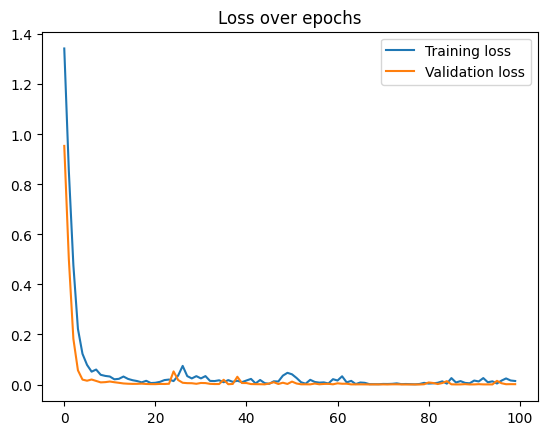

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

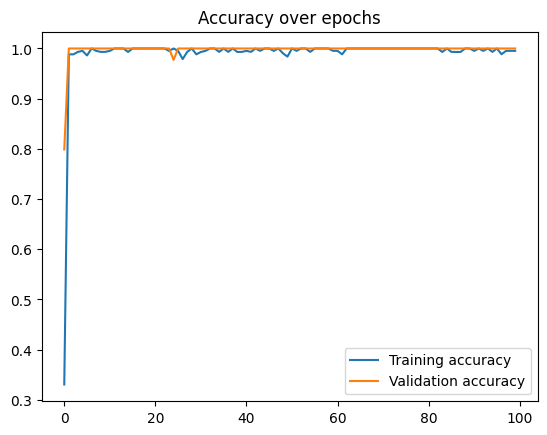

In [22]:
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Load MlFlow Registerd Model

model_name = "ResNet50_Freeze"
model_version = "1"
model = mlflow.pytorch.load_model(f"models:/{model_name}/{model_version}")

# Test Model with Seperated Test Data

In [23]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = os.path.join(MAIN_DIR, "test_data")
test_data, test_labels = [], []

for dir_ in os.listdir(TEST_FOLDER_DIR):
    path = os.path.join(TEST_FOLDER_DIR, dir_)

    for img in os.listdir(path):
        image_tensor = transformed_image(os.path.join(path, img))
        test_data.append(image_tensor)
        test_labels.append(dir_)


In [24]:
test_dataset = SignDataset(test_data, test_labels)
len(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset))

for data, label in test_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([35, 3, 224, 224])
torch.Size([35])


In [25]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            return outputs, labels

In [26]:
predicted, ground_truth = predict(model, test_dataloader)

accuracy = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
precision = Precision(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
recall = Recall(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
f1score = F1Score(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
print(predicted)
print(ground_truth)

tensor([[-1.3485, -1.6844, -2.4870,  3.9345],
        [ 2.7374, -2.8003, -1.4021,  0.1999],
        [ 0.9005, -0.1759, -1.1632, -0.4476],
        [ 1.5424, -0.6688, -1.5908,  0.1389],
        [ 1.8999, -3.1019,  2.3592, -1.8927],
        [-1.1340, -3.0187,  2.8039,  0.0727],
        [ 2.9432, -1.7856, -2.4563, -0.1514],
        [-0.0984, -2.3161, -0.3397,  1.3252],
        [ 4.9342, -1.9725, -2.8198, -1.5517],
        [-2.3708,  4.5473, -2.6904, -0.9378],
        [-0.7156,  0.5656,  0.3320, -0.6043],
        [-3.2002,  7.8487, -4.2394, -2.3977],
        [-2.2885,  3.4338, -1.6133, -0.8354],
        [-1.3525,  2.2386, -1.0835, -0.5744],
        [-1.9704,  3.2985, -1.3398, -1.3485],
        [-3.4410,  7.5760, -3.1642, -2.7501],
        [-1.8448,  2.7629, -2.0569, -0.5258],
        [-2.6347,  5.1481, -2.3390, -2.0426],
        [-3.8720,  7.4308, -3.9313, -1.7166],
        [-1.1441, -2.0067,  3.4512, -1.7290],
        [-1.6298, -0.1830,  2.2681, -1.4031],
        [-0.4427, -0.8216,  0.8688

In [28]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())

Accuracy: tensor(0.8611, device='cuda:0')
Precision: tensor(0.8750, device='cuda:0')
Recall: tensor(0.8611, device='cuda:0')
F1 Score: tensor(0.8450, device='cuda:0')


# Logging with MlFlow

In [29]:
# Log parameters 
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("learning_rate", 0.0001)
mlflow.log_param("weight_decay", 0.0)
mlflow.log_param("loss_function", "CrossEntropyLoss")
mlflow.log_param("epoch", 100)
mlflow.log_param("traing_batch_size", 16)
mlflow.log_param("validation_batch_size", 16)

16

In [30]:
# Log result
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("train_accuracy", train_acc)
mlflow.log_metric("validation_loss", val_loss)
mlflow.log_metric("validation_accuracy", val_acc)
mlflow.log_metric("test_accuracy", accuracy.compute())
mlflow.log_metric("test_precision", precision.compute())
mlflow.log_metric("test_recall", recall.compute())
mlflow.log_metric("test_f1", f1score.compute())

In [31]:
# Log dataset
mlflow.log_artifacts(DATA_DIR, artifact_path="dataset")
mlflow.log_artifacts(TEST_FOLDER_DIR, artifact_path="test_dataset")

In [32]:
# Log model
mlflow.pytorch.log_model(artifact_path="ResNet50_Unfreeze", pytorch_model=model, registered_model_name="ResNet50_Unfreeze")

2025/06/25 15:58:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/25 15:59:03 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/25 15:59:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'ResNet5